In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import iminuit
from iminuit import Minuit, cost
from numba_stats import norm, truncexpon, crystalball, expon
from scipy.optimize import curve_fit
import mplhep as hep
hep.style.use("LHCb2")

np.random.seed(42)

#read the data from the csv file
data = np.genfromtxt('/home/aavash/Downloads/data_from_lab/filtered_by_type/inv_mass_filtered_all_Bminus.csv', delimiter=',')
data_plus = np.genfromtxt('/home/aavash/Downloads/data_from_lab/filtered_by_type/inv_mass_filtered_all_Bminus.csv', delimiter=',')

In [3]:
BINS = 150


In [2]:
from numba import jit
@jit
def signal(x, mu, sigma, n):
    return n * norm.cdf(x, mu, sigma)

from scipy.stats import halfnorm
def combinatorial(x, mu, sigma, n):
    result = n * halfnorm.cdf(x, mu, sigma)
    # result = np.zeros(len(x))
    # result = np.where(x > 5100, n * norm.cdf(x, mu, sigma), 0)
    return result
@jit
def background(x, tau, xoffset, norm):
    result = norm * expon.cdf(x, xoffset, tau)
    return result
    #return norm * truncexpon.cdf(x, x[0], x[-1], xoffset, tau)

@jit
def cdf(x, norm_mu, norm_sigma, norm_n,
        comb_mu, comb_sigma, comb_n,
        tau, xoffset, norm,
        total_norm):
    
    signal_result = signal(x, norm_mu, norm_sigma, norm_n)
    combinatorial_result = combinatorial(x, comb_mu, comb_sigma, comb_n)
    background_result = background(x, tau, xoffset, norm)
    return total_norm*(signal_result + combinatorial_result + background_result)

@jit
def crystal_signal(x, beta, m, loc, scale, n):
    return n * crystalball.cdf(x, beta, m, loc, scale)
@jit
def cdf_crystal(x,
                crystal_beta, crystal_m, crystal_loc, crystal_scale, crystal_norm,
                comb_mu, comb_sigma, comb_n,
                tau, xoffset, norm,
                total_norm):
    
    signal_result = crystal_signal(x, crystal_beta, crystal_m, crystal_loc, crystal_scale, crystal_norm)
    combinatorial_result = combinatorial(x, comb_mu, comb_sigma, comb_n)
    background_result = background(x, tau, xoffset, norm)
    return total_norm*(signal_result + combinatorial_result + background_result)

def fit_crystal(x, beta, m , loc, scale, c_norm, 
                comb_mu, comb_sigma, comb_n,
                tau, xoffset, exp_norm, total_norm
                ):
    crystal_val = crystalball.pdf(x, beta, m, loc, scale) * c_norm
    comb_val = norm.pdf(x, comb_mu, comb_sigma) * comb_n
    exp_val = expon.pdf(x, tau, xoffset) * exp_norm
    return (crystal_val + comb_val + exp_val) * total_norm
def fit_curve_post_minut(data, p0_vals):
    #fit the data with a gaussian
    hist_raw = plt.hist(data, bins=BINS, histtype='step', label='raw data');
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heihgts = hist_raw[0]
    popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heihgts, p0=p0_vals)

    return popt, pcov

In [4]:
data_plus = np.genfromtxt("/home/aavash/Downloads/data_from_lab/from_todor/inv_mass_filtered_Bminus.csv", delimiter=",")

#take only data from 5100 to 5400
data_plus = data_plus[(data_plus > 5100) & (data_plus < 5600)]
n_plus, xe_plus = np.histogram(data_plus, bins=BINS)
c_crystal_plus = cost.ExtendedBinnedNLL(n_plus, xe_plus, cdf_crystal)

/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [5]:
n_plus_c = Minuit(     c_crystal_plus,
                crystal_beta=1.2,
                crystal_m=5,
                crystal_loc=5300,
                crystal_scale=4,
                crystal_norm=277,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=100,

                tau=1500,
                xoffset=4100,
                norm=1e3,

                total_norm=1e2)
n_plus_c.limits['crystal_m'] = (0, 20)
n_plus_c.limits['crystal_scale'] = (1, 100)
n_plus_c.limits['crystal_norm'] = (1, 1e4)
n_plus_c.limits['crystal_loc'] = (5200, 5400)

n_plus_c.limits['comb_mu'] = (5100, 5101)
n_plus_c.limits['comb_sigma'] = (1, 50)
n_plus_c.limits['comb_n'] = (1, 1e4)

n_plus_c.fixed["crystal_beta"] = True
n_plus_c.fixed["comb_mu"] = True
n_plus_c.migrad(iterate=20, ncall=300000).migrad()
n_plus_c.interactive()

/tmp/ipykernel_221723/1436018039.py:32: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cdf_crystal" failed type inference due to: Untyped global name 'combinatorial': Cannot determine Numba type of <class 'function'>

File "../../../../tmp/ipykernel_221723/1436018039.py", line 40:
<source missing, REPL/exec in use?>

  @jit
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "cdf_crystal" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_221723/1436018039.py", line 32:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.readth

In [6]:
array_p0_crystal = np.array([n_plus_c.values['crystal_beta'],
                            n_plus_c.values['crystal_m'],
                            n_plus_c.values['crystal_loc'],
                            n_plus_c.values['crystal_scale'],
                            n_plus_c.values['crystal_norm'],
                            n_plus_c.values['comb_mu'],
                            n_plus_c.values['comb_sigma'],
                            n_plus_c.values['comb_n'],
                            n_plus_c.values['tau'],
                            n_plus_c.values['xoffset'],
                            n_plus_c.values['norm'],
                            n_plus_c.values['total_norm']])
# print(array_p0_crystal)

n_plus_c.values['tau'] = 2100
epsilon = 1000
upper_crystal = array_p0_crystal + epsilon
lower_crystal = array_p0_crystal - epsilon

#free the normalisation parameters in the array_p0_crystal using index
lower_crystal[0] = array_p0_crystal[0] - 3e-1
upper_crystal[0] = array_p0_crystal[0] + 3e-1

upper_crystal[1] = array_p0_crystal[1] + 3e-1
lower_crystal[1] = array_p0_crystal[1] - 3e-1

upper_crystal[2] = array_p0_crystal[2] + 10
lower_crystal[2] = array_p0_crystal[2] - 10

upper_crystal[3] = array_p0_crystal[3] + 3e-1
lower_crystal[3] = array_p0_crystal[3] - 3e-1


upper_crystal[4] = 1e8
lower_crystal[4] = 1e-8

upper_crystal[7] = 1e8
lower_crystal[7] = 1e-8

upper_crystal[10] = 1e8
lower_crystal[10] = 1e-8

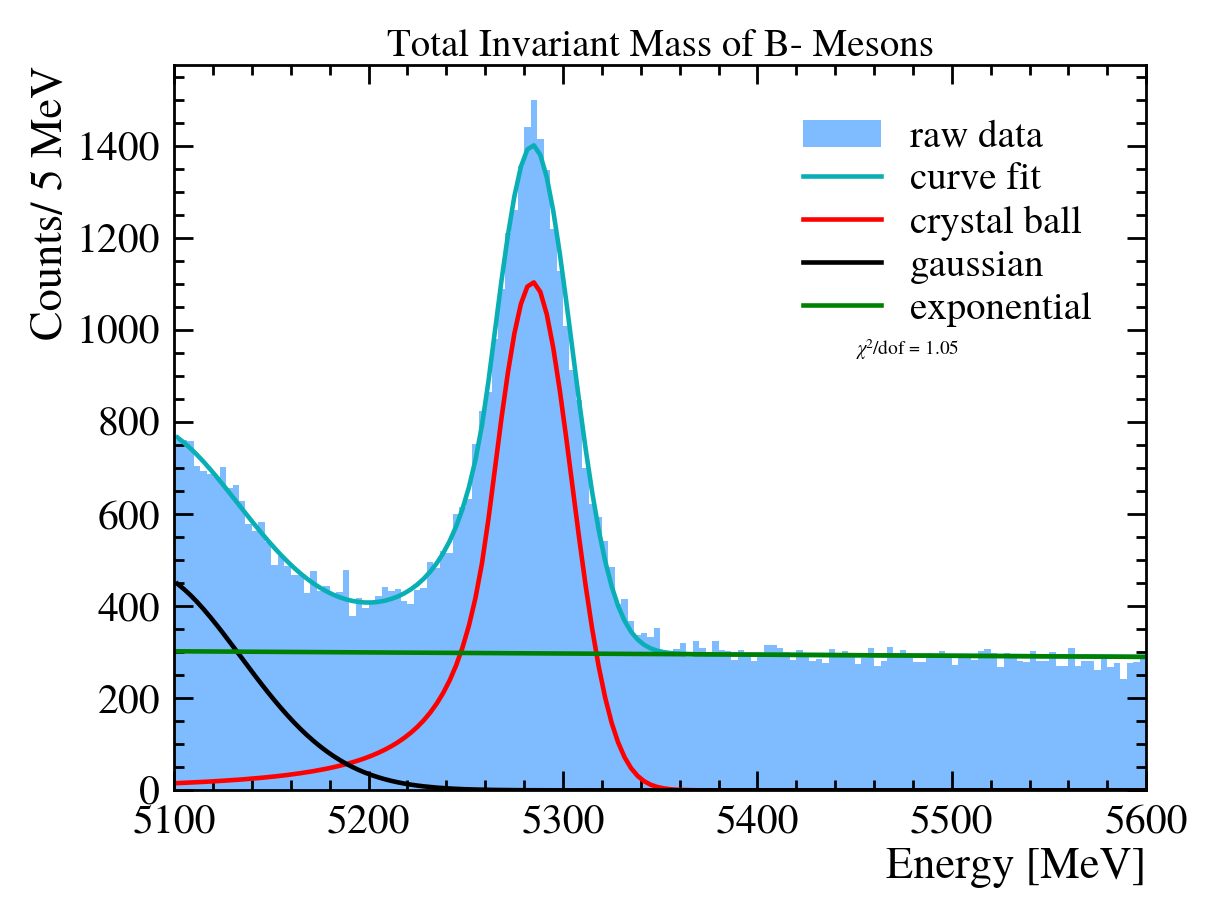

In [8]:
def fit_curve_post_minut_bounded(data, p0_vals, upper, lower):
    #fit the data with a gaussian
    hist_raw = plt.hist(data, bins=BINS, histtype='step', label='raw data');
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heihgts = hist_raw[0]
    unc_vals = np.sqrt(bin_heihgts)

    popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heihgts,
                            p0=p0_vals, bounds=(lower, upper),
                            sigma=unc_vals, absolute_sigma=True)
    plt.clf()
    return popt, pcov
# popt, pcov = fit_curve_post_minut(data_plus, 
#                                   [1.2, 3.066800708293673, 5283.866200116772,
#                                     20.679652920238063,160.86015229246274,
#                                     5100, 39.65547, 49.60, 1790.5, 5448.5,
#                                     1459, 114.939])

popt, pcov = fit_curve_post_minut_bounded(data_plus, array_p0_crystal, upper_crystal, lower_crystal)
hist_raw = plt.hist(data_plus, bins=BINS, label="raw data", color="C0", alpha=0.5)
bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]

crystal_part = crystalball.pdf(bin_centers, popt[0], popt[1], popt[2], popt[3]) * popt[4] * popt[-1]
comb_part = norm.pdf(bin_centers, popt[5], popt[6]) * popt[7] * popt[-1]
exp_part = expon.pdf(bin_centers, popt[8], popt[9]) * popt[10] * popt[-1]

total_part = crystal_part + comb_part + exp_part

#plot the fit
plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, crystal_part, label="crystal ball", color="red")
plt.plot(bin_centers, comb_part, label="gaussian", color="black")
plt.plot(bin_centers, exp_part, label="exponential", color="green")

#add labels 
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B- Mesons")
plt.xlim(5100, 5600)
negative_bin_centers = bin_centers
negative_comb_part = comb_part
negative_crystal_part = crystal_part
negative_exp_part = exp_part
negative_popt = popt
negative_bin_heights = bin_heights
negative_model = fit_crystal(bin_centers, *popt)
plt.legend()

B+


In [11]:
data_plus = np.genfromtxt("/home/aavash/Downloads/data_from_lab/from_todor/inv_mass_filtered_Bplus .csv", delimiter=",")

#take only data from 5100 to 5400
data_plus = data_plus[(data_plus > 5100) & (data_plus < 5600)]
n_plus, xe_plus = np.histogram(data_plus, bins=BINS)
c_crystal_plus = cost.ExtendedBinnedNLL(n_plus, xe_plus, cdf_crystal)

In [12]:
n_plus_c = Minuit(     c_crystal_plus,
                crystal_beta=1.2,
                crystal_m=5,
                crystal_loc=5300,
                crystal_scale=4,
                crystal_norm=277,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=100,

                tau=1500,
                xoffset=4100,
                norm=1e3,

                total_norm=1e2)
n_plus_c.limits['crystal_m'] = (0, 20)
n_plus_c.limits['crystal_scale'] = (1, 100)
n_plus_c.limits['crystal_norm'] = (1, 1e4)
n_plus_c.limits['crystal_loc'] = (5200, 5400)

n_plus_c.limits['comb_mu'] = (5100, 5101)
n_plus_c.limits['comb_sigma'] = (1, 50)
n_plus_c.limits['comb_n'] = (1, 1e4)

n_plus_c.fixed["crystal_beta"] = True
n_plus_c.fixed["comb_mu"] = True

n_plus_c.migrad(iterate=20, ncall=300000).migrad()
n_plus_c.interactive()

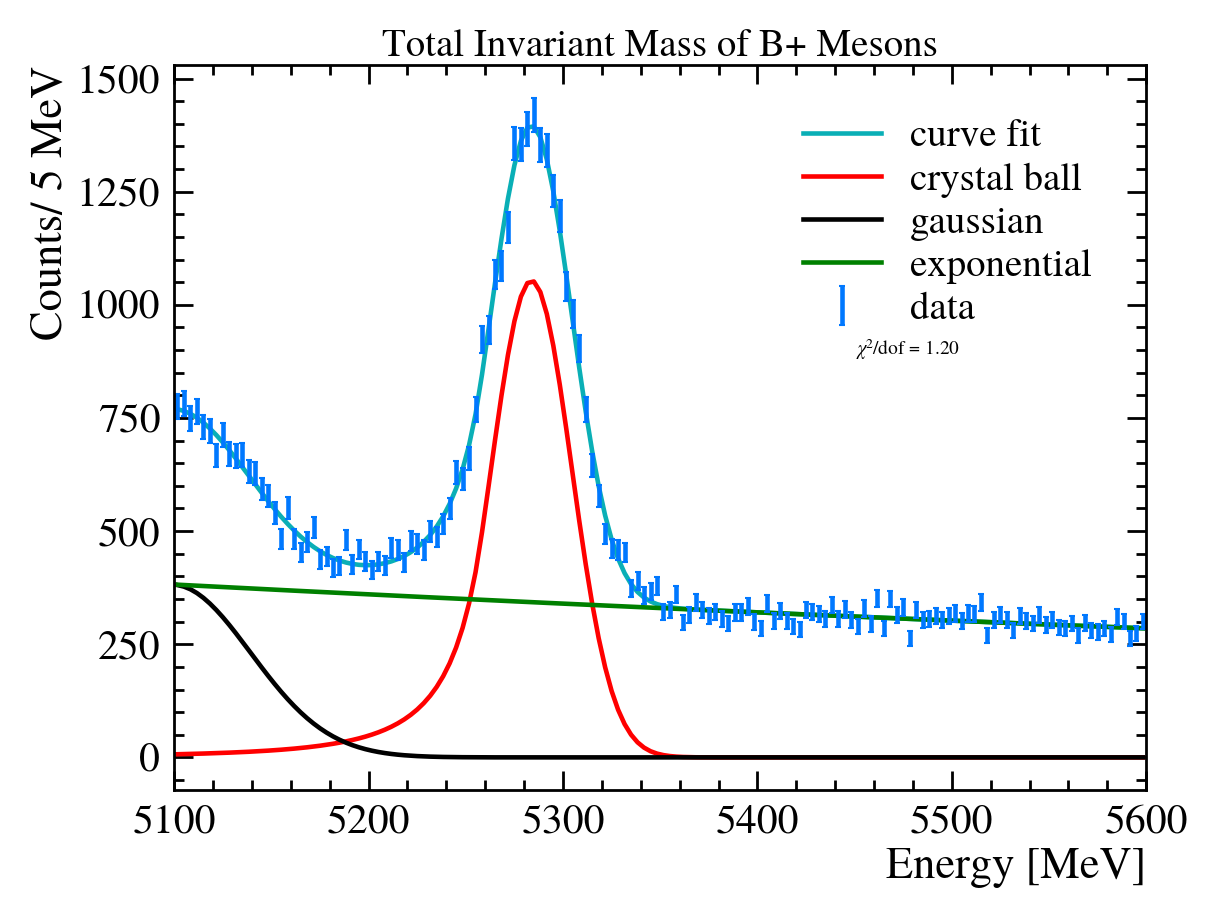

In [14]:
array_p0_crystal =  np.array(  [    1.2, 3.066800708293673, 5283.866200116772,
                                    20.679652920238063,160.86015229246274,
                                    5100, 50, 49.60, 80.5, 5000.5,
                                    1459, 114.939])

#extract 

epsilon = 200
upper_crystal = array_p0_crystal + epsilon
lower_crystal = array_p0_crystal - epsilon

#free the normalisation parameters in the array_p0_crystal using index
lower_crystal[0] = array_p0_crystal[0] - 1e-1
upper_crystal[0] = array_p0_crystal[0] + 1e-1

upper_crystal[1] = array_p0_crystal[1] + 1e-1
lower_crystal[1] = array_p0_crystal[1] - 1e-1


upper_crystal[4] = 1e8
lower_crystal[4] = 1e-8

upper_crystal[5] = 5101
lower_crystal[5] = 5099

upper_crystal[7] = 1e8
lower_crystal[7] = 1e-8

upper_crystal[8] = 1e8
lower_crystal[8] = 1e-8

upper_crystal[9] = 1e8
lower_crystal[9] = 1e-8

upper_crystal[10] = 1e8
lower_crystal[10] = 1e-8

def fit_curve_post_minut_bounded(data, p0_vals, upper, lower):
    #fit the data with a gaussian
    hist_raw = plt.hist(data, bins=BINS, histtype='step', label='raw data');
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heihgts = hist_raw[0]
    unc_vals = np.sqrt(bin_heihgts)

    popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heihgts, p0=p0_vals,
                            bounds=(lower, upper), sigma=unc_vals,
                              absolute_sigma=True)
    plt.clf()
    return popt, pcov

popt, pcov = fit_curve_post_minut_bounded(data_plus, array_p0_crystal, upper_crystal, lower_crystal)
hist_raw = plt.hist(data_plus, bins=BINS, label="raw data", color="C0", alpha=0.5)
plt.clf()
bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]

crystal_part = crystalball.pdf(bin_centers, popt[0], popt[1], popt[2], popt[3]) * popt[4] * popt[-1]
comb_part = norm.pdf(bin_centers, popt[5], popt[6]) * popt[7] * popt[-1]
exp_part = expon.pdf(bin_centers, popt[8], popt[9]) * popt[10] * popt[-1]

total_part = crystal_part + comb_part + exp_part

#plot the fit
plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, crystal_part, label="crystal ball", color="red")
plt.plot(bin_centers, comb_part, label="gaussian", color="black")
plt.plot(bin_centers, exp_part, label="exponential", color="green")

#plot data with error bars
#plt.scatter(bin_centers, bin_heights)
plt.errorbar(bin_centers, bin_heights, yerr=np.sqrt(bin_heights),
              label="data", color="C0",ls="None")
#add labels 
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof
positive_bin_centers = bin_centers 
positive_bin_heights = bin_heights
positive_total_part = total_part
positive_crystal_part = crystal_part
positive_comb_part = comb_part
positive_exp_part = exp_part
positive_model = fit_crystal(bin_centers, *popt)
positive_chi_squared = reduced_chi_squared
#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B+ Mesons")
plt.xlim(5100, 5600)

#add l
plt.legend()

/tmp/ipykernel_221723/4100320649.py:15: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0)


<Figure size 2500x100 with 0 Axes>

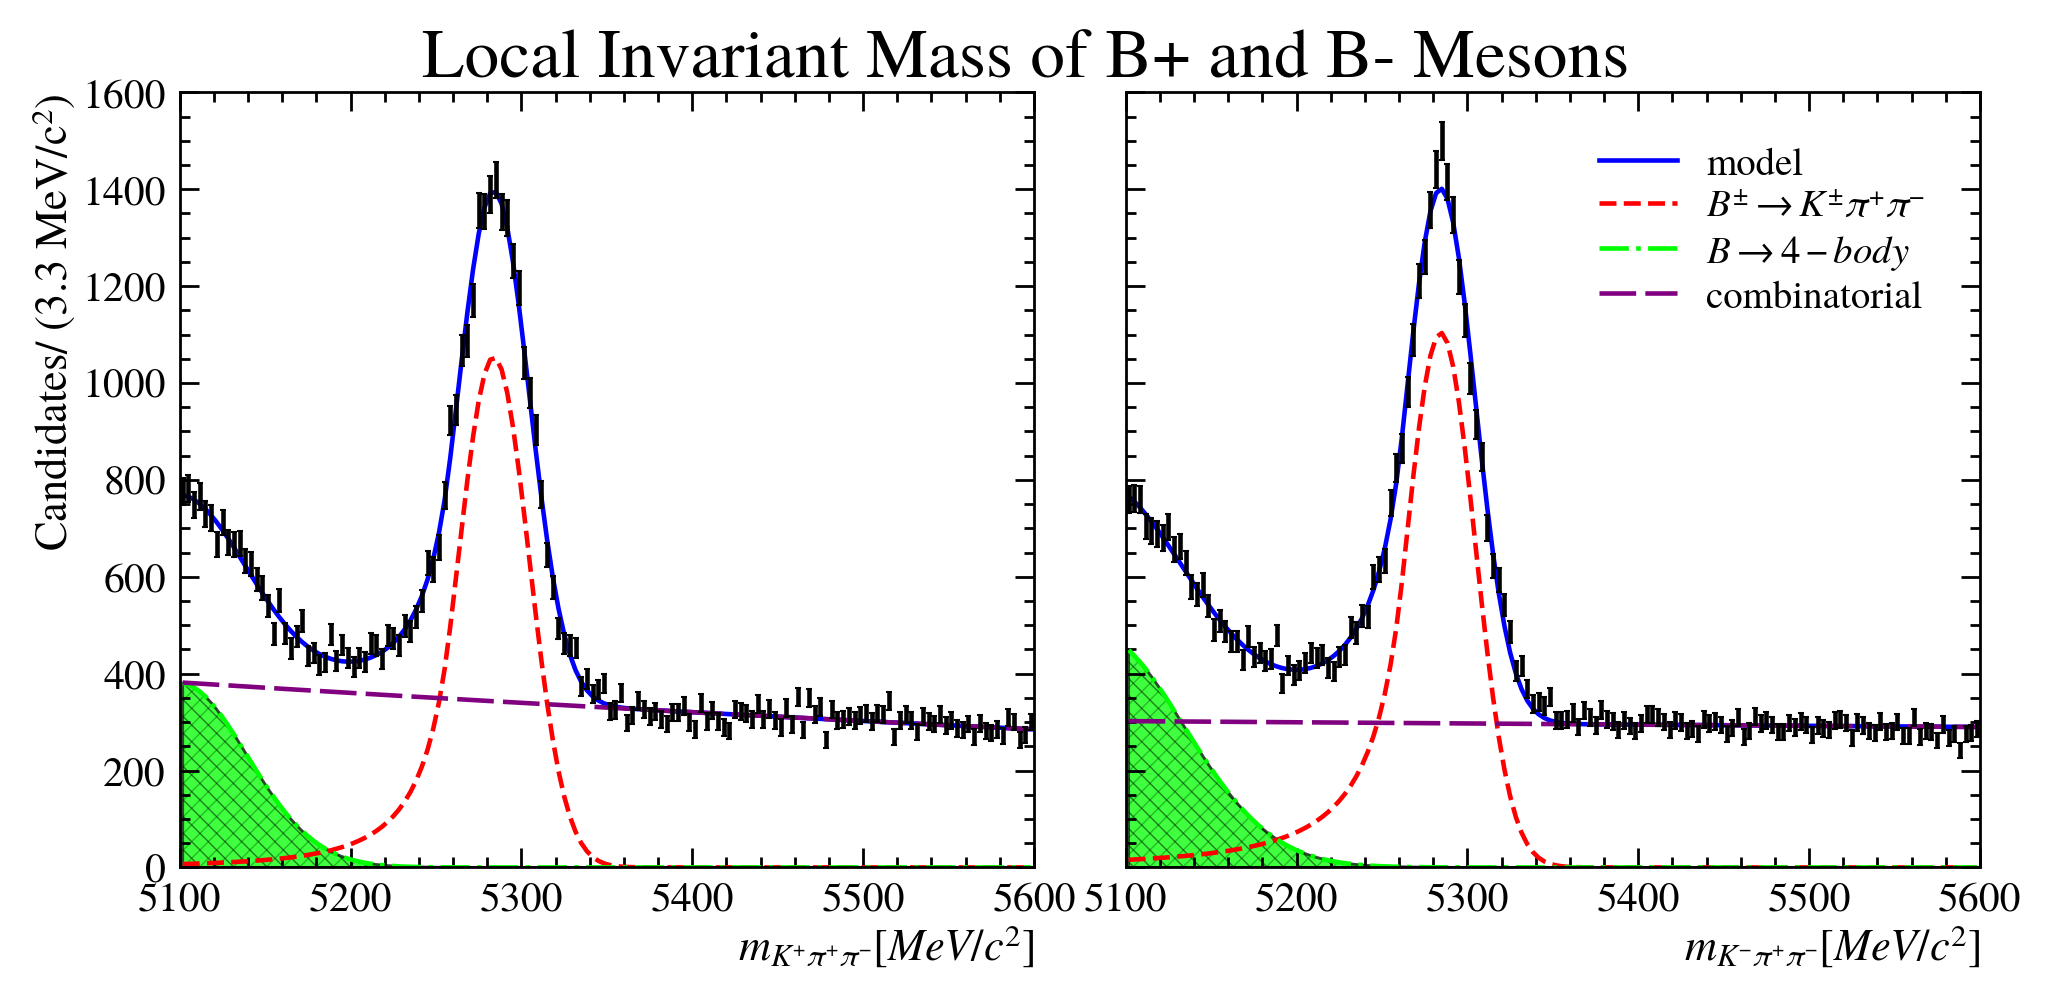

In [30]:
#plot the fits side by side
#change the size of the plot
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(25, 1))
plt.subplots_adjust(wspace=0)

# use two axes to plot the data and the fit parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9), sharey=True, constrained_layout=True,
                               gridspec_kw={'width_ratios': [1, 1],
                                            "wspace":0,
                                            })


#remove space between plots
fig.subplots_adjust(wspace=0)
#plot the positive results in ax1
ax1.plot(positive_bin_centers, positive_model, label="model", color="blue")
ax1.plot(positive_bin_centers, positive_crystal_part, label=r"$B^{\pm} \rightarrow K^{\pm}\pi^{+}\pi^{-}$", color="red",
            ls="dashed")    
ax1.plot(positive_bin_centers, positive_comb_part, label=r"$B \rightarrow 4-body$", color="lime", ls="-.")
ax1.plot(positive_bin_centers, positive_exp_part, label="combinatorial", dashes=[8,2], color="purple")
ax1.fill_between(positive_bin_centers, 0, positive_comb_part, where=positive_comb_part > 0, hatch="//", alpha=0.5, color='lime',
                    edgecolor="black")
ax1.fill_between(positive_bin_centers, 0, positive_comb_part, where=positive_comb_part > 0, hatch="\\\\", alpha=0.5, color='lime',
                    edgecolor="black")

#limit view to y > 0
ax1.set_ylim(bottom=0, top=1600)
#plot data with error bars
#make the gap between the two plots 0
ax1.errorbar(positive_bin_centers, positive_bin_heights, yerr=np.sqrt(positive_bin_heights),
                color="black",ls="None")

#plot the negative results in ax2
ax2.plot(negative_bin_centers, negative_model, label="model", color="blue")
ax2.plot(negative_bin_centers, negative_crystal_part, label=r"$B^{\pm} \rightarrow K^{\pm}\pi^{+}\pi^{-}$", color="red",
            ls="dashed")    
ax2.plot(negative_bin_centers, negative_comb_part, label=r"$B \rightarrow 4-body$", color="lime", ls="-.")
ax2.plot(negative_bin_centers, negative_exp_part, label="combinatorial", dashes=[8,2], color="purple")
ax2.fill_between(negative_bin_centers, 0, negative_comb_part, where=negative_comb_part > 0, hatch="//", alpha=0.5, color='lime',
                    edgecolor="black")
ax2.fill_between(negative_bin_centers, 0, negative_comb_part, where=negative_comb_part > 0, hatch="\\\\", alpha=0.5, color='lime',
                    edgecolor="black")

ax2.errorbar(negative_bin_centers, negative_bin_heights, yerr=np.sqrt(negative_bin_heights),
                color="black",ls="None")

#reduce the gap between the two axis to 0

#set the y-axis title for both plots
ax1.set_ylabel(f"Candidates/ ({500/BINS:.1f} MeV/c$^2$)")
#set the y-label for both plots
ax1.set_xlabel(r"$m_{K^{+}\pi^{+}\pi^{-}} [MeV/c^2]$")

ax2.set_xlabel(r"$m_{K^{-}\pi^{+}\pi^{-}} [MeV/c^2]$")

#set a title of local invariant mass of B+ and B- and put in the middle
fig.suptitle("Local Invariant Mass of B+ and B- Mesons", fontsize=50, y=1.05)

#set the x-axis limits for both plots
ax1.set_xlim(5100, 5600)
ax2.set_xlim(5100, 5600)

ax2.legend(loc="upper right")
#plt.title("Local Invariant Mass of B+ and B- Mesons")

In [26]:
n_plus_c.ndof

140.0

In [ ]:
n